# Opcode usage - exploratory analysis

#### Maria Silva, March 2025

## 1. Imports and settings

Let's start by importing the necessary libraries and setting up some directories and files.


In [5]:
import os
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Main directories and files
current_path = os.getcwd()
repo_dir = os.path.abspath(os.path.join(current_path, ".."))
data_dir = os.path.join(repo_dir, "data")
op_files_dir = os.path.join(data_dir, "aggregated_opcodes_v2", "*", "file.parquet")

## 2. Load data

Now, let's load the data. We will start by loading the opcodes used for blocks 22000000 to 22001999.

In [7]:
# Load parquet files with duckdb
query = f"""
SELECT block_height, tx_hash, op, op_gas_cost, op_gas_pair_count
FROM read_parquet(
    '{op_files_dir}', 
    hive_partitioning=True, 
    filename=True,
    file_row_number=True,
    union_by_name=True
    )
WHERE block_height BETWEEN 22000000 AND 22001999;
"""
raw_usage_df = duckdb.connect().execute(query).fetchdf()
# Print info
raw_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23276 entries, 0 to 23275
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   block_height       23276 non-null  int64  
 1   tx_hash            23276 non-null  object 
 2   op                 23276 non-null  object 
 3   op_gas_cost        23276 non-null  float64
 4   op_gas_pair_count  23276 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 909.3+ KB


In [8]:
raw_usage_df["block_height"].agg(["min", "max"])

min    22000036
max    22000042
Name: block_height, dtype: int64

Now, we can load the gas used per transaction.

In [9]:
# Load parquet file
tx_gas_usage_df = pd.read_parquet(
    os.path.join(data_dir, "tx_gas_usage_22000000_22006000.parquet")
)
# Clean up columns
tx_gas_usage_df = tx_gas_usage_df.drop(columns=["block_height"])
tx_gas_usage_df.columns = [
    "tx_hash",
    "tx_gas_cost",
    "tx_input_data_gas_cost",
    "is_contract_creation",
]
# Print info
tx_gas_usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937679 entries, 0 to 937678
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   tx_hash                 937679 non-null  object
 1   tx_gas_cost             937679 non-null  int64 
 2   tx_input_data_gas_cost  937679 non-null  int64 
 3   is_contract_creation    937679 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 28.6+ MB


## 3. Process data

In [10]:
# Add total transaction gas
usage_df = raw_usage_df.merge(tx_gas_usage_df, on="tx_hash", how="left")
# Fix op_gas_cost for transactions with no opcodes
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])) & (usage_df["is_contract_creation"]==0),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 21000.0,
    usage_df["op_gas_cost"],
)
usage_df["op_gas_cost"] = np.where(
    (usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])) & (usage_df["is_contract_creation"]==1),
    usage_df["tx_gas_cost"] - usage_df["tx_input_data_gas_cost"] - 53000.0,
    usage_df["op_gas_cost"],
)
# Clean up repeated opcodes
usage_df["op"] = np.where(usage_df["op"].str.startswith("DUP"), "DUP", usage_df["op"])
usage_df["op"] = np.where(usage_df["op"].str.startswith("SWAP"), "SWAP", usage_df["op"])
usage_df["op"] = np.where(
    (usage_df["op"].str.startswith("PUSH")) & (usage_df["op"] != "PUSH0"),
    "PUSH",
    usage_df["op"],
)
# Compute total gas cost for opcode
usage_df["op_total_gas_cost"] = usage_df["op_gas_cost"] * usage_df["op_gas_pair_count"]
# Print info
usage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23276 entries, 0 to 23275
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   block_height            23276 non-null  int64  
 1   tx_hash                 23276 non-null  object 
 2   op                      23276 non-null  object 
 3   op_gas_cost             23276 non-null  float64
 4   op_gas_pair_count       23276 non-null  int64  
 5   tx_gas_cost             23276 non-null  int64  
 6   tx_input_data_gas_cost  23276 non-null  int64  
 7   is_contract_creation    23276 non-null  int64  
 8   op_total_gas_cost       23276 non-null  float64
dtypes: float64(2), int64(5), object(2)
memory usage: 1.6+ MB


## 4. Opcode usage overview

### Opcode usage counts

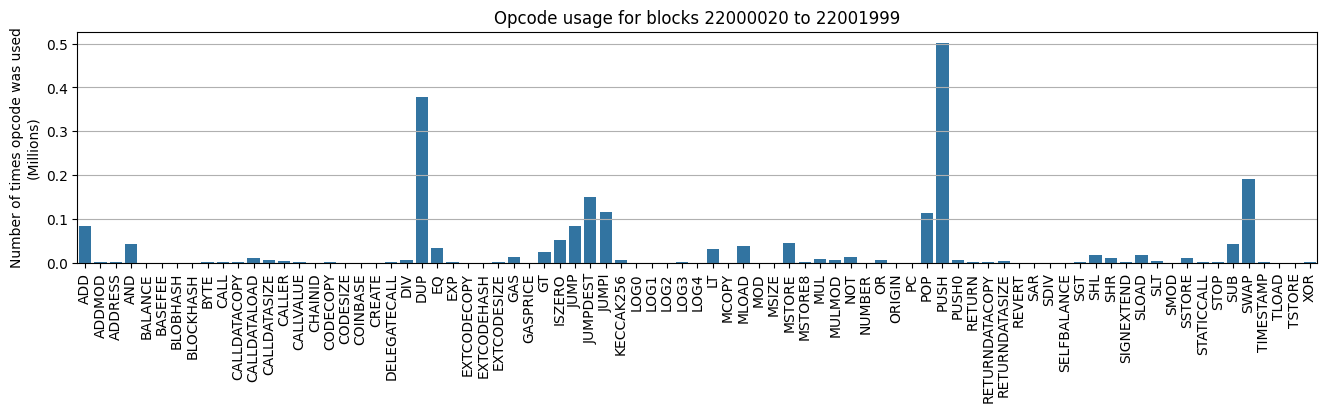

In [11]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
)
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"] / 1_000_000
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df)
plt.xticks(rotation=90)
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Number of times opcode was used\n(Millions)")
plt.xlabel("")
plt.show()

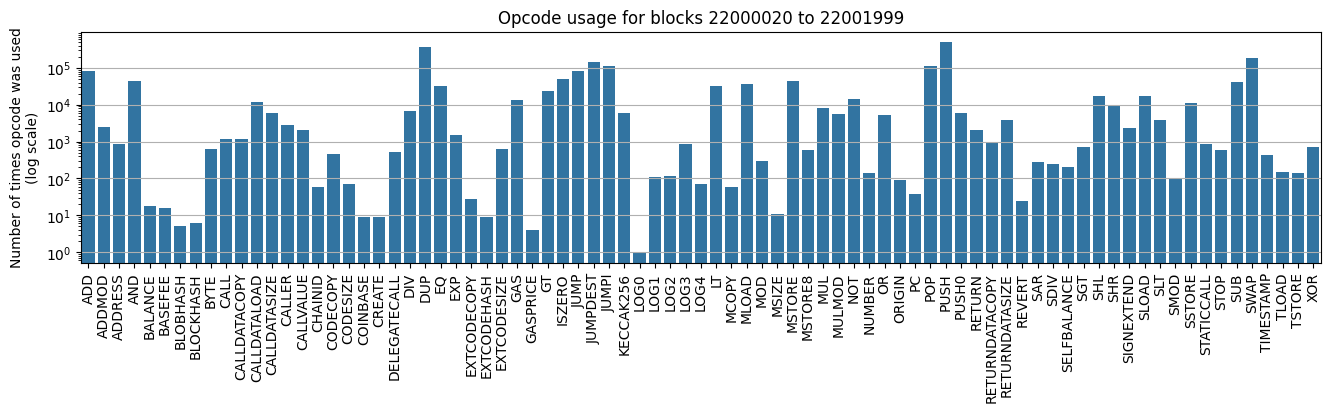

In [12]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_gas_pair_count"]
    .sum()
    .reset_index()
)
temp_df["op_gas_pair_count"] = temp_df["op_gas_pair_count"]
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_gas_pair_count", data=temp_df)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Number of times opcode was used\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode gas usage

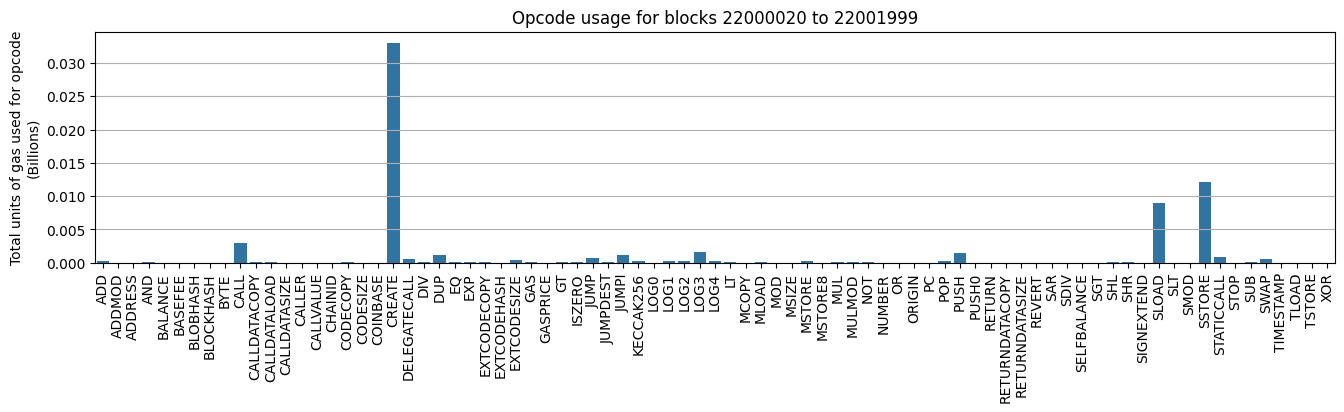

In [13]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
)
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"] / 1_000_000_000
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df)
plt.xticks(rotation=90)
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Total units of gas used for opcode\n(Billions)")
plt.xlabel("")
plt.show()

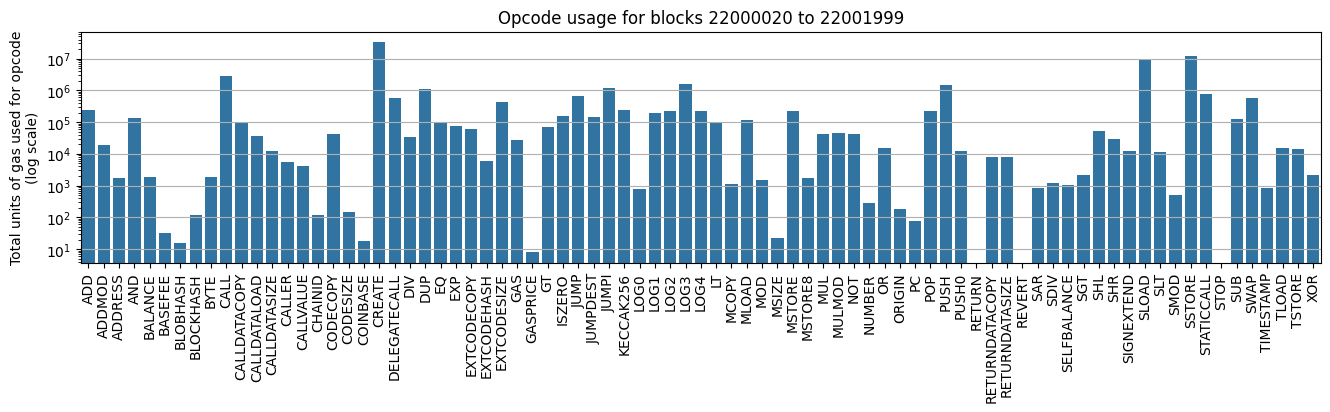

In [14]:
temp_df = (
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])]
    .groupby("op")["op_total_gas_cost"]
    .sum()
    .reset_index()
)
temp_df["op_total_gas_cost"] = temp_df["op_total_gas_cost"]
plt.figure(figsize=(16, 3))
plt.grid()
sns.barplot(x="op", y="op_total_gas_cost", data=temp_df)
plt.xticks(rotation=90)
plt.yscale("log")
plt.title("Opcode usage for blocks 22000020 to 22001999")
plt.ylabel("Total units of gas used for opcode\n(log scale)")
plt.xlabel("")
plt.show()

### Opcode usage correlation

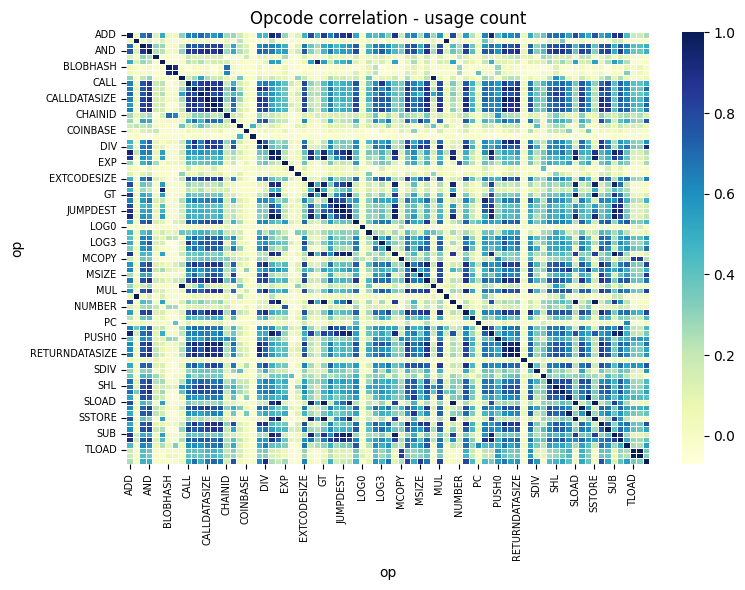

In [15]:
temp_df = pd.pivot_table(
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])],
    values="op_gas_pair_count",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - usage count")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.tight_layout()
plt.show()

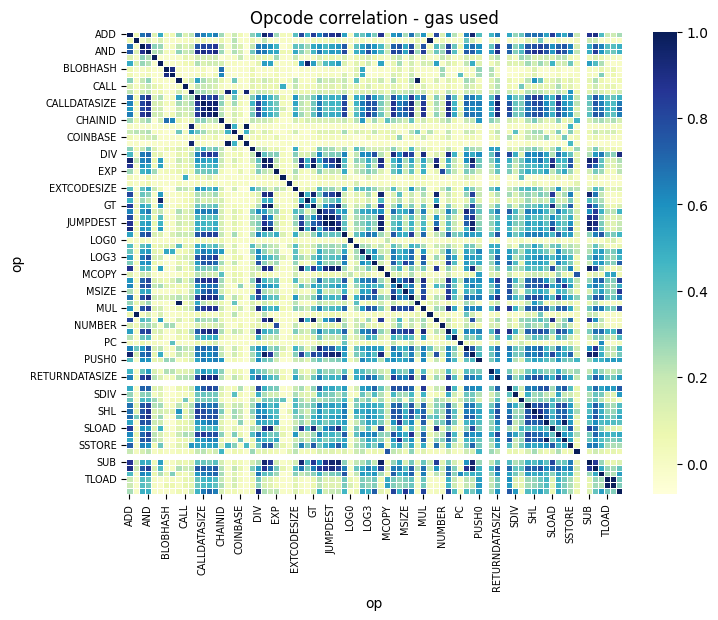

In [16]:
temp_df = pd.pivot_table(
    usage_df[~usage_df["op"].isin(["NO_TRACE", "RESPONSE_TOO_LARGE"])],
    values="op_total_gas_cost",
    index="tx_hash",
    columns="op",
    aggfunc="sum",
    fill_value=0.0,
)
corr_mat = temp_df.corr()
plt.figure(figsize=(8, 6))
ax = sns.heatmap(corr_mat, cmap="YlGnBu", linewidths=0.5)
plt.title("Opcode correlation - gas used")
ax.tick_params(axis="x", labelsize=7)
ax.tick_params(axis="y", labelsize=7)
plt.show()

## 5. Opcode gas usage vs transaction gas usage

Next, we will compare the total gas cost of the transaction with the cost of all opcodes used in the transaction. There are four main components to consider:

1. The intrinsic cost of the transaction, which is a fixed value of 21000 gas units or 53000 gas units when the transaction is a contract creation.
2. The cost of the input data, which costs 4 gas units for each zero bytes and 16 gas units for each non-zero byte.
3. The cost of the opcodes, which is the sum of all opcodes used in the transaction.
4. The gas refunds applied at the end of the transaction, which reduces the total gas cost. These refunds are triggered when the transaction uses the `SSTORE` opcode to set a storage slot to zero.

We already have the input data cost computed, and we can add the opcode costs from our data. The intrinsic cost is trivial. So, the final piece we need to compute is the gas refund. For simplicity, we will assume that the gas refund will be the difference between the total gas used by the transaction and the remaining terms.


In [17]:
op_tx_df = (
    usage_df.groupby(["block_height", "tx_hash"])
    .agg(
        {
            "op_total_gas_cost": "sum",
            "tx_gas_cost": "first",
            "tx_input_data_gas_cost": "first",
            "is_contract_creation": "max",
        }
    )
    .reset_index()
)
op_tx_df.columns = [
    "block_height",
    "tx_hash",
    "op_gas_cost",
    "tx_gas_cost",
    "tx_input_data_cost",
    "is_contract_creation",
]
op_tx_df["tx_gas_refund_estimated"] = np.where(
    op_tx_df["is_contract_creation"]==1,
    op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 53000.0 - op_tx_df["tx_gas_cost"],
    op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 21000.0 - op_tx_df["tx_gas_cost"],
)
op_tx_df["tx_gas_refund_rate"] =  np.where(
    op_tx_df["is_contract_creation"]==1,
    op_tx_df["tx_gas_refund_estimated"]/(op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 53000.0),
    op_tx_df["tx_gas_refund_estimated"]/(op_tx_df["op_gas_cost"] + op_tx_df["tx_input_data_cost"] + 21000.0),
)
op_tx_df.head()

,block_height,tx_hash,op_gas_cost,tx_gas_cost,tx_input_data_cost,is_contract_creation,tx_gas_refund_estimated,tx_gas_refund_rate
0,22000036,0x002c86f365d74615df9b26a22f73b2b79831547363bd...,0.0,21000,0,0,0.0,0.000000
1,22000036,0x011ddf30a78487fd85910ba2f1e02cb64b2036911111...,151775.0,168403,428,0,4800.0,0.027713
2,22000036,0x01e063dc906f77c0f0364be7e68f7d47095977ca0b53...,41601.0,63209,608,0,0.0,0.000000
3,22000036,0x0210c986f5613ac75c7b916c9974fa9149f1efeaa1b6...,24501.0,41297,596,0,4800.0,0.104128
4,22000036,0x04262c7ed2a7ca3982e5afa1dbd4b02ea6d92de23a74...,0.0,21000,0,0,0.0,0.000000


Let's check the gas refunds.

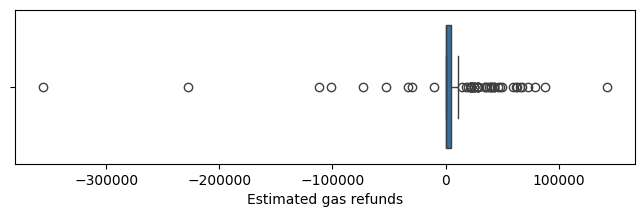

In [18]:
plt.figure(figsize=(8, 2))
sns.boxplot(data=op_tx_df, x="tx_gas_refund_estimated")
plt.xlabel("Estimated gas refunds")
plt.show()

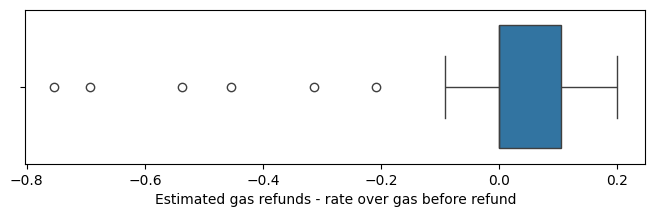

In [19]:
plt.figure(figsize=(8, 2))
sns.boxplot(data=op_tx_df, x="tx_gas_refund_rate")
plt.xlabel("Estimated gas refunds - rate over gas before refund")
plt.show()

In [21]:
sum(op_tx_df["tx_gas_refund_rate"]>0.2)/len(op_tx_df)

0.0

In [22]:
sum(op_tx_df["tx_gas_refund_rate"]<0)/len(op_tx_df)

0.019313304721030045

## 6. Investigate missing gas cases

In [23]:
negative_refund_op_tx_df = op_tx_df[op_tx_df["tx_gas_refund_rate"]<0]
negative_refund_op_tx_df

,block_height,tx_hash,op_gas_cost,tx_gas_cost,tx_input_data_cost,is_contract_creation,tx_gas_refund_estimated,tx_gas_refund_rate
24,22000036,0x1f66b5cf647549e11947a1945758cc174cf7e89906f2...,1091922.0,1490902,22180,0,-355800.0,-0.313452
109,22000036,0xea3c01d2f3fcfab703c688a30bd07605b8e00cdc369a...,118189.0,158985,9196,0,-10600.0,-0.071436
116,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,48417.0,106605,3888,0,-33300.0,-0.454266
129,22000040,0x0ed9eed9fff08dc1ffcfad3660f8fcfb33fee5e4b464...,456436.0,589384,10548,0,-101400.0,-0.207794
152,22000040,0x3a1b5b63f6730803e94b7b5eaebb8dc6a5b4b2a5bcf4...,75644.0,150922,1588,0,-52690.0,-0.536383
178,22000040,0x66b1f75ad2f3745a048ca43f356a13a8a79e69b2e84e...,294898.0,355550,9752,0,-29900.0,-0.091816
209,22000040,0xa7ec902d3f3355fd8e3874bc5787ea2fe1899443b2b2...,306827.0,555703,276,0,-227600.0,-0.693685
214,22000040,0xb3bb996d94e02f8f2f6410892432835086d8e190b206...,2965442.0,3121742,23500,0,-111800.0,-0.037144
329,22000041,0xca9c8baf3681a904c6413e170243bc1cfebdcd46bb3a...,31840.0,168930,11440,1,-72650.0,-0.754570


In [50]:
# set block and tx
block_height = 22000036
tx_hash = "0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8da827f9c1a2e4be22cdf"
# Define query
filename = os.path.join(
    data_dir, "block_data", f"block_height={block_height}", f"tx_hash={tx_hash}", "file.parquet"
)
query = f"""
SELECT block_height,
    tx_hash,
    file_row_number,
    op,
    depth,
    gas,
    gasCost,
    CASE
        WHEN op IN ('DELEGATECALL', 'CALL', 'CALLCODE', 'STATICCALL')
            AND depth < LEAD(depth, 1, depth) OVER (ORDER BY tx_hash, file_row_number)
        THEN gasCost - LEAD(gas, 1, 0) OVER (ORDER BY tx_hash, file_row_number)
        WHEN op IN ('DELEGATECALL', 'CALL', 'CALLCODE', 'STATICCALL')
            AND depth = LEAD(depth, 1, depth) OVER (ORDER BY tx_hash, file_row_number)
        THEN gas - LEAD(gas, 1, 0) OVER (ORDER BY tx_hash, file_row_number)
        ELSE gasCost
    END AS gasCost_v2
FROM read_parquet(
        '{ filename }',
        hive_partitioning = TRUE,
        filename = True,
        file_row_number = True,
        union_by_name = True
    )
ORDER BY block_height, tx_hash, file_row_number;
"""
con = duckdb.connect()
df = con.execute(query).fetchdf()
con.close()

df

,block_height,tx_hash,file_row_number,op,depth,gas,gasCost,gasCost_v2
0,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,0,PUSH1,1,99423,3,3
1,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,1,PUSH1,1,99420,3,3
2,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,2,MSTORE,1,99417,12,12
3,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,3,PUSH1,1,99405,3,3
4,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,4,CALLDATASIZE,1,99402,2,2
...,...,...,...,...,...,...,...,...
2547,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,2547,PUSH2,1,51024,3,3
2548,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,2548,JUMPI,1,51021,10,10
2549,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,2549,RETURNDATASIZE,1,51011,2,2
2550,22000036,0xf3ac160467762fb6e44efe990e6d1ff4cd340f55d9a8...,2550,PUSH1,1,51009,3,3


In [51]:
df["has_depth_increase"] = df["depth"] < df["depth"].shift(-1)
df["has_depth_decrease"] = df["depth"] > df["depth"].shift(-1)
df["has_depth_change"] = df["depth"] != df["depth"].shift(-1)

change_depth_row_numbers = df[df["has_depth_change"]]["file_row_number"].values
filter_row_numbers = np.unique(
    np.concat(
        (
            change_depth_row_numbers,
            change_depth_row_numbers + 1,
            change_depth_row_numbers - 1,
        )
    )
)
filter_rows_df = df[df["file_row_number"].isin(filter_row_numbers)].sort_values(
    "file_row_number"
)
filter_rows_df[["op", "depth", "gas", "gasCost", "gasCost_v2", "has_depth_increase"]]

,op,depth,gas,gasCost,gasCost_v2,has_depth_increase
131,GAS,1,98678,2,2,False
132,DELEGATECALL,1,98676,97175,2600,True
133,PUSH1,2,94575,3,3,False
1418,GAS,2,87575,2,2,False
1419,STATICCALL,2,87573,86207,100,True
1420,PUSH1,3,86107,3,3,False
1551,GAS,3,85434,2,2,False
1552,DELEGATECALL,3,85432,84138,2600,True
1553,PUSH1,4,81538,3,3,False
1621,SWAP1,4,81172,3,3,False


In [44]:
print(df["gas"].iloc[0]-df["gas"].iloc[-1])
print(df["gasCost_v2"].sum())

294898
294898


In [45]:
df["depth"].unique()

array([1, 2, 3, 4, 5, 6, 7])